# Preprocessing of WorldCupDataset

In [155]:
# install needed dependencies
% pip install pandas matplotlib seaborn networkx

UsageError: Line magic function `%` not found.


## Load Data

In [6]:
# load data

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

france_file_path = "../data/raw/WorldCupDataset/Teams/France.csv"
france_data = pd.read_csv(france_file_path)

croatia_file_path = "../data/raw/WorldCupDataset/Teams/Croatia.csv"
croatia_data = pd.read_csv(croatia_file_path)

france_argentina_match_file_path = "../data/raw/WorldCupDataset/matches/7580.csv"
france_argentina_match_data = pd.read_csv(france_argentina_match_file_path)

france_denmark_match_file_path = "../data/raw/WorldCupDataset/matches/7563.csv"
france_denmark_match_data = pd.read_csv(france_denmark_match_file_path)

## Define Data Used

In [16]:
# TODO: change df to the data you want to preprocessing here
df = france_denmark_match_data
file_prefix = "france_denmark"

## Replace None Values in duration with 0 and adjust endTime

In [17]:
france_data

,caseID,action,type,technique,play_pattern,under_pressure,shot_assist,angle,length,height,...,start_Y,end_X,end_Y,bad_behavior,result,home_team,away_team,action_type,action_count,action_type_count
0,7546101,Ball Recovery,None,None,Regular Play,True,None,NaN,NaN,NaN,...,8.0,NaN,NaN,None,None,Peru,France,Ball Recovery_None,Ball Recovery_1,Ball Recovery_None_1
1,7546101,Dribble,None,None,Regular Play,None,None,NaN,NaN,NaN,...,8.0,NaN,NaN,None,Complete,Peru,France,Dribble_None,Dribble_1,Dribble_None_1
2,7546101,Pass,None,None,Regular Play,None,None,2.743070,20.615528,NaN,...,10.0,47.0,18.0,None,None,Peru,France,Pass_None,Pass_1,Pass_None_1
3,7546101,Pass,None,None,Regular Play,None,None,1.341564,30.805843,NaN,...,25.0,55.0,55.0,None,None,Peru,France,Pass_None,Pass_2,Pass_None_2
4,7546101,Pass,None,None,Regular Play,None,None,-2.622447,8.062258,NaN,...,54.0,48.0,50.0,None,None,Peru,France,Pass_None,Pass_3,Pass_None_3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3765,864998,Pass,None,None,From Throw In,True,None,-1.538549,31.016125,NaN,...,48.0,94.0,17.0,None,None,France,Uruguay,Pass_None,Pass_14,Pass_None_9
3766,864998,Pass,None,None,From Throw In,None,None,0.226799,13.341664,NaN,...,18.0,111.0,21.0,None,None,France,Uruguay,Pass_None,Pass_15,Pass_None_10
3767,864999,Pass,Corner,None,From Corner,None,None,1.687905,34.234486,NaN,...,2.0,115.0,36.0,None,Incomplete,France,Uruguay,Pass_Corner,Pass_1,Pass_Corner_1
3768,864999,Ball Recovery,None,None,From Corner,True,None,NaN,NaN,NaN,...,54.0,NaN,NaN,None,None,France,Uruguay,Ball Recovery_None,Ball Recovery_1,Ball Recovery_None_1


In [18]:

# Filter rows where duration is None
missing_duration_actions = df[df['duration'].isnull()]

# Print the action types with missing duration
print("Action types with None duration:")
print(missing_duration_actions['action'].value_counts())
print("\nAction types total count:")
print(df['action'].value_counts())

# i don't know how to deal with missing duration, so i just set them to 0
df['duration'].fillna(0, inplace=True)

# Replace missing endTime with startTime where duration is 0
missing_end_time = df['endTime'].isnull()
df.loc[(df['duration'] == 0) | missing_end_time | df['endTime'].isna(), 'endTime'] = df['startTime']
df.loc[df['endTime'].isna(), 'endTime'] = df['startTime']

# Convert startTime and endTime to datetime objects
df['startTime'] = pd.to_datetime(df['startTime'])
df['endTime'] = pd.to_datetime(df['endTime'])

# Replace endTime format with "yyyy-MM-dd HH:mm:ss.SSS"
df['endTime'] = df['endTime'].dt.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]  # Remove last three digits

df.loc[df['endTime'].isna(), 'endTime'] = df['startTime']
df['endTime'] = pd.to_datetime(df['endTime'])


df.to_csv(f"../data/interim/{file_prefix}_without_none_duration.csv", index=False)

# comments from Lena: in the blog article he only uses the startTime in Disco as timestamp
# https://fluxicon.com/blog/2019/10/process-mining-meets-football-how-does-a-football-team-possess-the-ball-on-the-pitch/


Action types with None duration:
Ball Recovery     103
Miscontrol         29
Dribble            28
Clearance          28
Block              27
Dribbled Past      21
Foul Committed     21
Goal Keeper        19
Interception       15
Name: action, dtype: int64

Action types total count:
Pass              1041
Pressure           283
Ball Recovery      103
Miscontrol          29
Dribble             28
Clearance           28
Block               27
Dribbled Past       21
Foul Committed      21
Goal Keeper         19
Shot                16
Interception        15
Name: action, dtype: int64


## Add Zones to Data

In [20]:
# Add zones to data

# Define the X and Y boundaries of each zone
X_END = 120
Y_END = 80

x_boundaries = [0, X_END * 0.15, X_END * 0.5, X_END * 0.85, X_END]
y_boundaries = [0, Y_END * 0.2, Y_END * 0.8, Y_END]

# Define the corresponding zone names
zone_names = ['Zone 1', 'Zone 2', 'Zone 3', 'Zone 4', 'Zone 5', 'Zone 6', 'Zone 7', 'Zone 8', 'Zone 9', 'Zone 10', 'Zone 11', 'Zone 12']

# Create a function to map X and Y coordinates to zones
def map_to_zone(x, y):
    for i, x_boundary in enumerate(x_boundaries[:-1]):
        for j, y_boundary in enumerate(y_boundaries[:-1]):
            if (x_boundary <= x < x_boundaries[i + 1] or i == len(x_boundaries) - 2) and \
               (y_boundary <= y < y_boundaries[j + 1] or j == len(y_boundaries) - 2):
                return zone_names[i + (j * (len(x_boundaries) - 1))]
    return zone_names[-1]    

# Apply the mapping function to 'start_X' and 'start_Y' columns
df['zoneStart'] = df.apply(lambda row: map_to_zone(row['start_X'], row['start_Y']), axis=1)

# Apply the mapping function to 'end_X' and 'end_Y' columns
df['zoneEnd'] = df.apply(lambda row: map_to_zone(row['end_X'], row['end_Y']), axis=1)

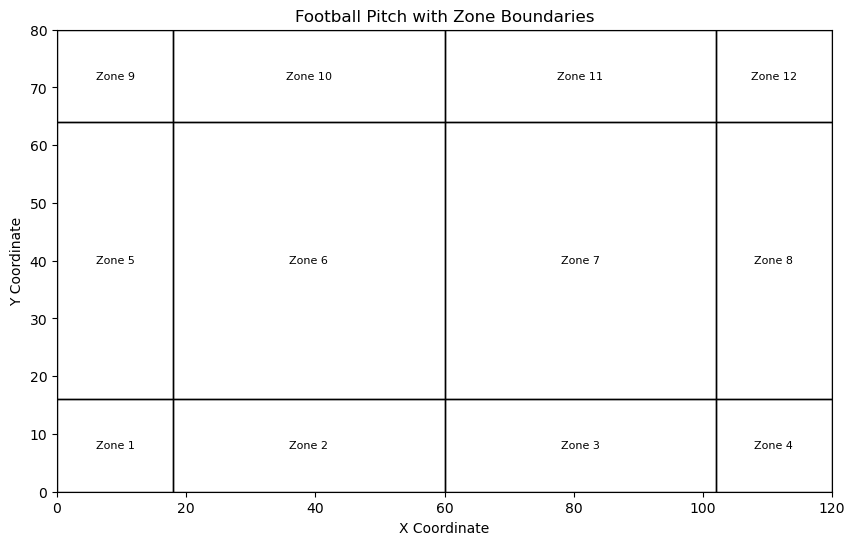

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_pitch(ax=None):
    if ax is None:
    # Create a figure and axis if ax is not provided
        fig, ax = plt.subplots(figsize=(10, 6))

    # Plot zone boundaries
    for i in range(len(x_boundaries) - 1):
        for j in range(len(y_boundaries) - 1):
            x_start, x_end = x_boundaries[i], x_boundaries[i + 1]
            y_start, y_end = y_boundaries[j], y_boundaries[j + 1]

            # Create a rectangle patch for each zone
            rect = patches.Rectangle((x_start, y_start), x_end - x_start, y_end - y_start,
                                    linewidth=1, edgecolor='black', facecolor='none')

            # Add the rectangle to the plot
            ax.add_patch(rect)

            # Add zone name inside the rectangle
            zone_name = zone_names[i + j * (len(x_boundaries) - 1)]
            ax.text((x_start + x_end) / 2, (y_start + y_end) / 2, zone_name,
                    horizontalalignment='center', verticalalignment='center',
                    fontsize=8, color='black')

    # Customize the plot
    plt.title('Football Pitch with Zone Boundaries')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.xlim(0, X_END)
    plt.ylim(0, Y_END)

plot_pitch()


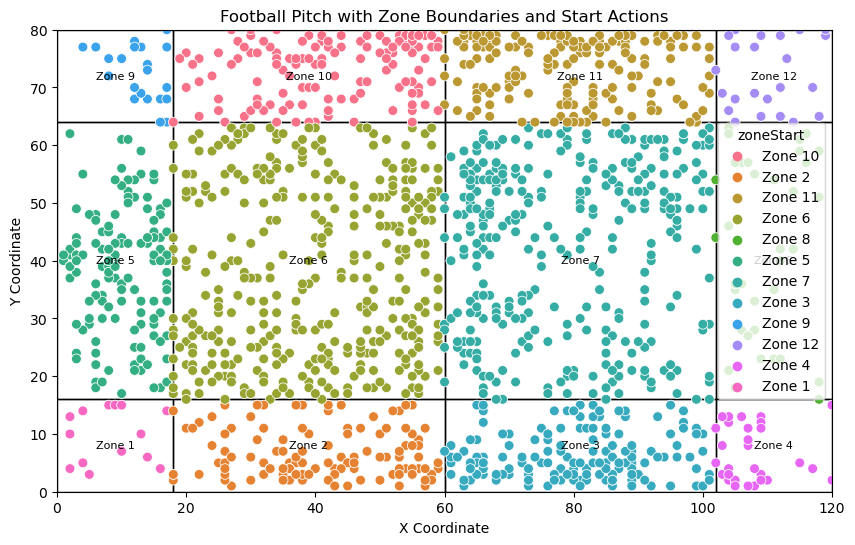

In [22]:
# Visualizing Start Actions on Pitch

fig, ax = plt.subplots(figsize=(10, 6))

# Call the plot_pitch function with the provided axis
plot_pitch(ax=ax)

# Plot actions with starting and ending points
sns.scatterplot(x='start_X', y='start_Y', data=df, hue='zoneStart', marker='o', s=50, ax=ax)
# sns.scatterplot(x='end_X', y='end_Y', data=df, hue='zoneEnd', marker='X', s=50, ax=ax)

# Customize the plot
plt.title('Football Pitch with Zone Boundaries and Start Actions')

# Show the plot
plt.show()

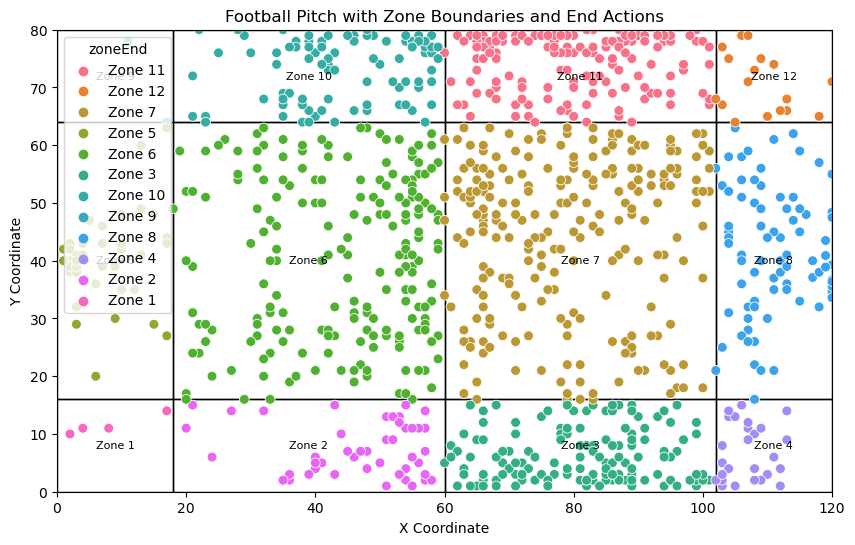

In [23]:
# Visualizing End Actions on Pitch
fig, ax = plt.subplots(figsize=(10, 6))

# Call the plot_pitch function with the provided axis
plot_pitch(ax=ax)

# Plot actions with starting and ending points
# sns.scatterplot(x='start_X', y='start_Y', data=df, hue='zoneStart', marker='o', s=50, ax=ax)
sns.scatterplot(x='end_X', y='end_Y', data=df, hue='zoneEnd', marker='o', s=50, ax=ax)

# Customize the plot
plt.title('Football Pitch with Zone Boundaries and End Actions')


# Show the plot
plt.show()

Number of actions for each startZone:
Zone 6     381
Zone 7     332
Zone 11    192
Zone 3     165
Zone 10    148
Zone 5     142
Zone 2     134
Zone 8      40
Zone 4      32
Zone 12     30
Zone 9      21
Zone 1      14
Name: zoneStart, dtype: int64

Number of actions for each endZone:
Zone 12    575
Zone 7     245
Zone 6     205
Zone 11    156
Zone 3     153
Zone 10     90
Zone 8      87
Zone 2      48
Zone 5      40
Zone 4      26
Zone 1       4
Zone 9       2
Name: zoneEnd, dtype: int64


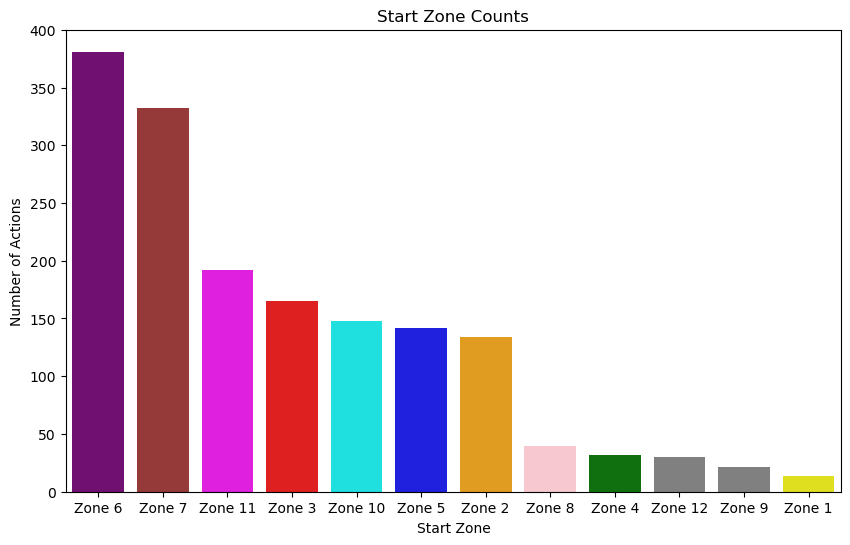

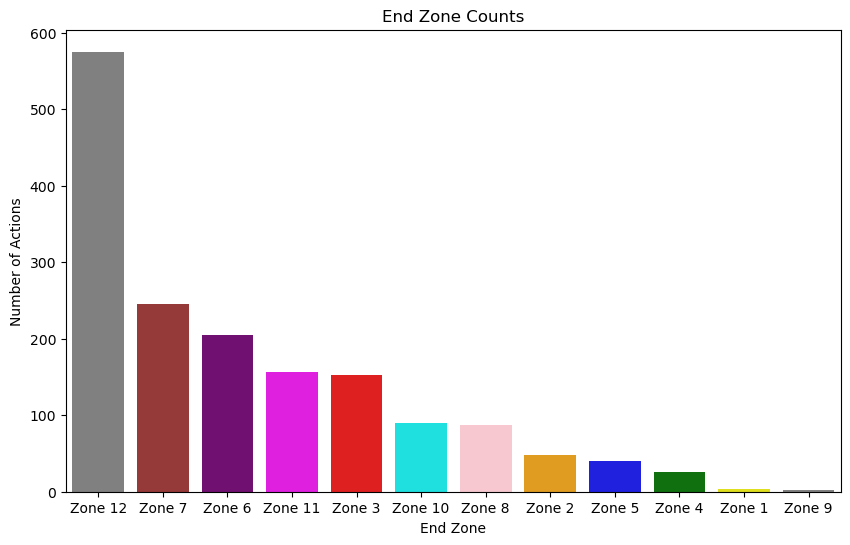

In [24]:
# Count the number of actions for each startZone and endZone
start_zone_counts = df['zoneStart'].value_counts()
end_zone_counts = df['zoneEnd'].value_counts()

# Print the counts
print("Number of actions for each startZone:")
print(start_zone_counts)

print("\nNumber of actions for each endZone:")
print(end_zone_counts)

zone_colors = {
    'Zone 1': 'yellow',
    'Zone 2': 'orange',
    'Zone 3': 'red',
    'Zone 4': 'green',
    'Zone 5': 'blue',
    'Zone 6': 'purple',
    'Zone 7': 'brown',
    'Zone 8': 'pink',
    'Zone 9': 'gray',
    'Zone 10': 'cyan',
    'Zone 11': 'magenta',
    'Zone 12': 'grey'
}

start_zone_colors = start_zone_counts.index.map(zone_colors)


# Visualize the start_zone_counts in a histogram
plt.figure(figsize=(10, 6))
sns.barplot(x=start_zone_counts.index, y=start_zone_counts.values, palette=start_zone_colors)
plt.title('Start Zone Counts')
plt.xlabel('Start Zone')
plt.ylabel('Number of Actions')
plt.show()

end_zone_colors = end_zone_counts.index.map(zone_colors)


plt.figure(figsize=(10, 6))
sns.barplot(x=end_zone_counts.index, y=end_zone_counts.values, palette=end_zone_colors)
plt.title('End Zone Counts')
plt.xlabel('End Zone')
plt.ylabel('Number of Actions')
plt.show()

In [25]:
# Save Data with Zones
df.to_csv(f"../data/interim/{file_prefix}_with_zones.csv", index=False)

## Finding Match Data for Comparision of France vs Argentina (4:3) & France vs Denmark (0:0)

In [4]:
import os
import pandas as pd

# Specify the directory path
directory_path = "../data/raw/WorldCupDataset/matches/"

# Iterate over all files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):  # Adjust the file extension as needed
        file_path = os.path.join(directory_path, filename)

        # Read the data from the current file
        football_data = pd.read_csv(file_path)

        # Check if there is a match where home_team is "France" and away_team is "Argentina"
        interesting_match_condition = ((football_data['home_team'] == 'France') & (football_data['away_team'] == 'Argentina')) | ((football_data['home_team'] == 'Argentina') & (football_data['away_team'] == 'France'))
        
        boring_match_condition = ((football_data['home_team'] == 'France') & (football_data['away_team'] == 'Denmark')) | ((football_data['home_team'] == 'Denmark') & (football_data['away_team'] == 'France'))

        if interesting_match_condition.any():
            print(f"Interesting match found in file: {filename}") # 7580.csv
        if boring_match_condition.any():
            print(f"Boring match found in file: {filename}") # 7563.csv


Interesting match found in file: 7580.csv
Boring match found in file: 7563.csv
